In [109]:
#plotly libraries
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np

import sklearn.metrics as metrics
import pandas as pd
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

#default renderer (svg means very small file size, visibility on github, high quality, but requires sometimes setting height and width)
pio.renderers.default = "svg"

colors = ["#363b3d", "#727b76", "#31a240", "#f93939", "#f79118", "#de7b06", "#9b308f", "#dc759b"]
#additional defaults
px.defaults.color_discrete_sequence = ["rgb(100,100,100)"] + pc.qualitative.D3
px.defaults.width=1000
px.defaults.height=800

#try setting this as default for histograms
#fig.update_traces(marker_line_width=0.2)

#set default template as "simple_white" (no background, no grid lines)
pio.templates["simple_white"].layout["yaxis"]["showgrid"] = True
pio.templates.default = "simple_white"

colorscale = pc.sequential.Plasma
colorscale = [colorscale[0]] + colorscale[3:8]

['#0d0887', '#46039f', '#7201a8', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a', '#fdca26', '#f0f921']


['#0d0887', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a']

In [110]:
import os
#data_folder is the path to the data director, where different types of data are stored (fastq, bam, rna framework output, perbase, etc.)
data_folder = f"{os.getcwd()}/data"


In [111]:
import pandas as pd
samplesheet = pd.read_excel("Samplesheet_example.xlsx", engine="openpyxl")
samples = samplesheet["sample"].values

sample sequencing run    barcode
0    Nanopore_HIV1_Rep1_RT-US_0mM_cell           Run1  barcode01
1   Nanopore_HIV1_Rep1_RT-US_57mM_cell           Run1  barcode05
2   Nanopore_HIV1_Rep1_RT-US_85mM_cell           Run1  barcode06
3    Nanopore_HIV1_Rep2_RT-US_0mM_cell           Run2  barcode01
4   Nanopore_HIV1_Rep2_RT-US_57mM_cell           Run2  barcode05
5   Nanopore_HIV1_Rep2_RT-US_85mM_cell           Run2  barcode06
6    Nanopore_HIV1_Rep1_RT-FS_0mM_cell           Run1  barcode21
7   Nanopore_HIV1_Rep1_RT-FS_57mM_cell           Run1  barcode25
8   Nanopore_HIV1_Rep1_RT-FS_85mM_cell           Run1  barcode26
9    Nanopore_HIV1_Rep2_RT-FS_0mM_cell           Run2  barcode21
10  Nanopore_HIV1_Rep2_RT-FS_57mM_cell           Run2  barcode25
11  Nanopore_HIV1_Rep2_RT-FS_85mM_cell           Run2  barcode26

In [113]:
# Same isoforms as in 1_Nano-DMS-MaP

read_counts_df = pd.read_pickle(f"{data_folder}/isoquant/read_counts.pickle")
per_replicate_df = pd.pivot(read_counts_df, index = ["RT_and_DMS", "isoform_id"], columns = "replicate", values = "count").reset_index()
per_replicate_df

min_cov = 200
min_cov_df = per_replicate_df[(per_replicate_df["Rep1"] > min_cov) & (per_replicate_df["Rep2"] > min_cov)]
isoforms_per_combined_sample = min_cov_df.groupby("RT_and_DMS").agg({"isoform_id" : list}).to_dict()["isoform_id"]

## Mean mutation rates (perbase)

Calculate empirical mean error rate (from bam files generated with LAST)

In [236]:
figure_dir = f"{os.getcwd()}/figures/mut_rates"
os.makedirs(figure_dir, exist_ok=True)

In [114]:
bamstats_folder = f"{data_folder}/bam_stats"
os.makedirs(bamstats_folder, exist_ok=True)

# read in perbase output

tmp_data = []
for sample in samples:
    
    combined_sample = "_".join(sample.split("_")[3:5]) # update with sample naming scheme
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    sample_outfolder = f"{bamstats_folder}/{sample}/"
    os.makedirs(sample_outfolder, exist_ok=True)
    
    commands = []
    for isoform in sample_isoforms:
        
        perbase_outfile = f"{sample_outfolder}/perbase_{sample}_{isoform}.tsv.gz"
        tmp_df = pd.read_csv(perbase_outfile, sep="\t")
        tmp_df["sample"] = sample
        tmp_data.append(tmp_df)
perbase_df = pd.concat(tmp_data)

In [115]:
#remove N counts from total number (to calculate percentage)
perbase_df["DEPTH"] = perbase_df["DEPTH"] - perbase_df["N"]

print("Total number of nt read in:", perbase_df["DEPTH"].sum())

Total number of nt read in: 482444760


In [117]:
#pivot df so that we can calculate % values easily
tmp_df = pd.melt(perbase_df, id_vars=["REF", "POS", "REF_BASE", "DEPTH", "NEAR_MAX_DEPTH", "sample"], value_vars =["A", "C", "G", "T", "N", "INS", "DEL", "REF_SKIP", "FAIL"], value_name="count")
pivot_df = tmp_df[tmp_df["variable"] != "N"].copy()
pivot_df["percent"] = 100*pivot_df["count"]/pivot_df["DEPTH"]
pivot_df.loc[pivot_df["DEPTH"] <1, "percent"] = np.nan

#convert all ref bases to upper to fix grouping
pivot_df["REF_BASE"] = pivot_df["REF_BASE"].str.upper()

#new column to easily filter out correct basecalls
pivot_df["match"] = pivot_df["REF_BASE"] == pivot_df["variable"]


In [118]:
#extract information from samples as separate columns for plotting; assumes sample as "{replicate}_{RT_primer}_{DMS_conc}_{localization}"

pivot_df["replicate"] = pivot_df["sample"].apply(lambda x: x.split("_")[2])
pivot_df["RT"] = pivot_df["sample"].apply(lambda x: x.split("_")[3])
pivot_df["conc"] = pivot_df["sample"].apply(lambda x: x.split("_")[4])

In [121]:
#ensures samples are always plotted in the same order when specifying as category_orders in plotly
order_dict = {"conc" : ["0mM", "57mM", "85mM"], #"8mM", "17mM", "34mM"", ,
              "replicate" : ["Rep1", "Rep2"],
             "REF_BASE" : ["A", "C", "G", "T"],
             "variable" : ["A", "C", "G", "T", "INS", "DEL", "REF_SKIP"]}

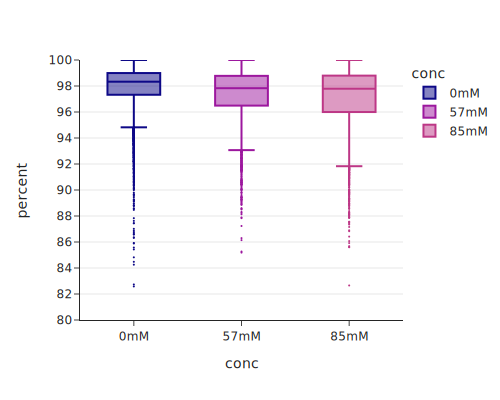

In [122]:
fig = px.box(pivot_df[(pivot_df["match"]) & (pivot_df["DEPTH"]>1000)], color="conc",x="conc",  y="percent", category_orders = order_dict, color_discrete_sequence =colorscale)
fig.update_yaxes(range=[80,100], dtick=2)
fig.update_layout(height=400, width=500)
fig.update_traces(marker_size=2)
fig.show(renderer="png")

In [134]:
mismatch_df = pivot_df[~pivot_df["match"]]
mismatch_df = mismatch_df[mismatch_df["variable"].isin(["A", "C", "G", "T"])]

#filter for single nucleotide mismatches only, i.e. without indels
snm_df = mismatch_df.groupby(["REF", "POS", "REF_BASE", "sample", "replicate", "RT", "conc", "DEPTH"]).agg({"percent" : "sum"}).reset_index()
snm_df

REF  POS REF_BASE                              sample  \
0      RT1_unspliced1    1        G  Nanopore_HIV1_Rep1_RT-FS_57mM_cell   
1      RT1_unspliced1    1        G  Nanopore_HIV1_Rep1_RT-FS_85mM_cell   
2      RT1_unspliced1    1        G   Nanopore_HIV1_Rep1_RT-US_0mM_cell   
3      RT1_unspliced1    1        G  Nanopore_HIV1_Rep1_RT-US_57mM_cell   
4      RT1_unspliced1    1        G  Nanopore_HIV1_Rep1_RT-US_85mM_cell   
...               ...  ...      ...                                 ...   
81521       RT3_sORF3  731        A  Nanopore_HIV1_Rep1_RT-FS_57mM_cell   
81522       RT3_sORF3  731        A  Nanopore_HIV1_Rep1_RT-FS_85mM_cell   
81523       RT3_sORF3  731        A   Nanopore_HIV1_Rep2_RT-FS_0mM_cell   
81524       RT3_sORF3  731        A  Nanopore_HIV1_Rep2_RT-FS_57mM_cell   
81525       RT3_sORF3  731        A  Nanopore_HIV1_Rep2_RT-FS_85mM_cell   

      replicate     RT  conc  DEPTH  percent  
0          Rep1  RT-FS  57mM    559      0.0  
1          Rep1  RT-FS  85mM    583      0.0  
2          Rep1  RT-US   0mM  19877      0.0  
3          Rep1  RT-US  57mM  26049      0.0  
4          Rep1  RT-US  85mM  40573      0.0  
...         ...    ...   ...    ...      ...  
81521      Rep1  RT-FS  57mM    142      0.0  
81522      Rep1  RT-FS  85mM    153      0.0  
81523      Rep2  RT-FS   0mM    244      0.0  
81524      Rep2  RT-FS  57mM    352      0.0  
81525      Rep2  RT-FS  85mM    359      0.0  

[81526 rows x 9 columns]

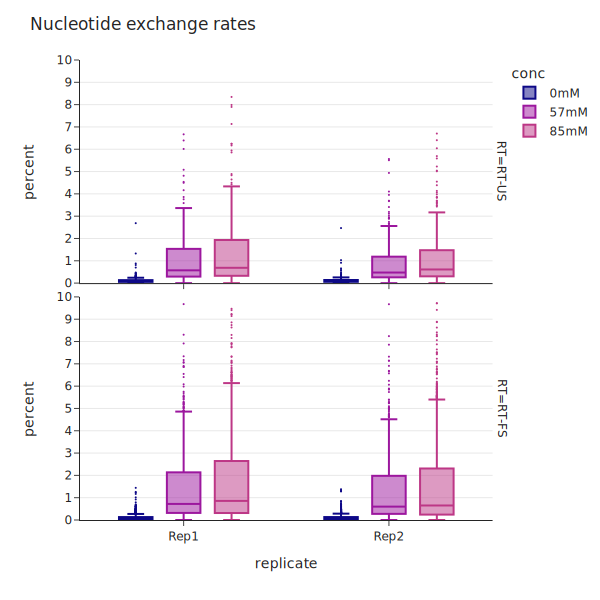

In [212]:
fig = px.box(snm_df[snm_df["DEPTH"]>1000], color="conc",x="replicate", facet_row="RT",  y="percent", category_orders = order_dict, color_discrete_sequence =colorscale)
fig.update_yaxes(range=[0,10], dtick=1)
fig.update_layout(height=600, width=600)
fig.update_traces(marker_size=2)
fig.update_layout(title="Nucleotide exchange rates")
fig.write_image(f"{figure_dir}/nanopore_snm_rate_box.svg")
fig.show(renderer="png")

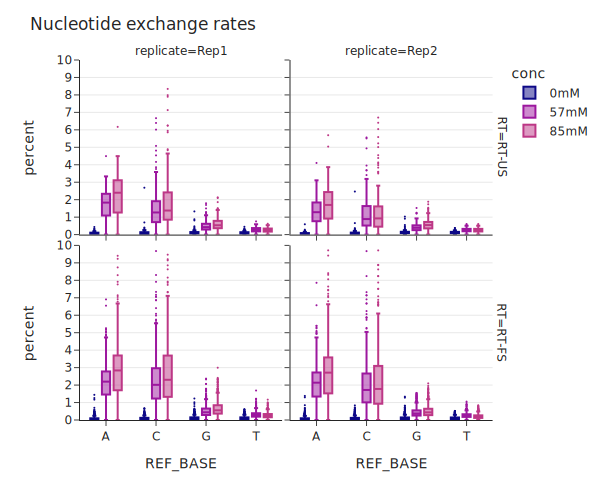

In [238]:
fig = px.box(snm_df[snm_df["DEPTH"]>1000], color="conc",facet_col="replicate", facet_row="RT", x="REF_BASE", y="percent", category_orders = order_dict, color_discrete_sequence =colorscale)
fig.update_yaxes(range=[0,10], dtick=1)
fig.update_layout(height=500, width=600)
fig.update_traces(marker_size=2)
fig.update_layout(title="Nucleotide exchange rates")
fig.write_image(f"{figure_dir}/nanopore_snm_rate_per_nt_box.svg")
fig.show(renderer="png")

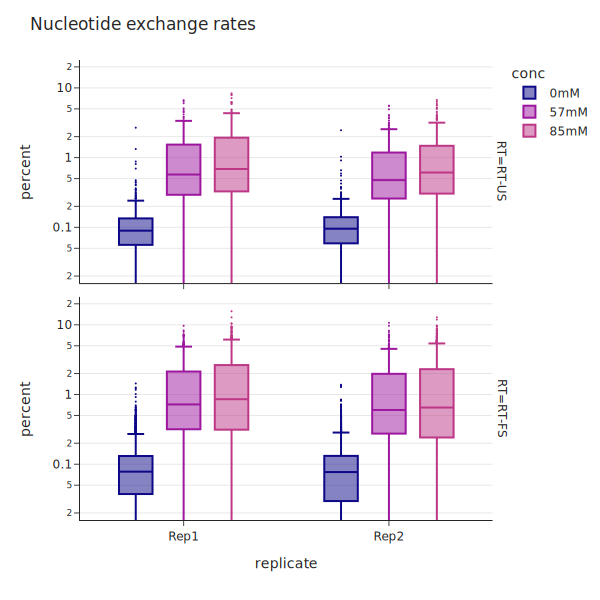

In [214]:
fig = px.box(snm_df[snm_df["DEPTH"]>1000], log_y=True, color="conc",x="replicate", facet_row="RT",  y="percent", category_orders = order_dict, color_discrete_sequence =colorscale)
fig.update_yaxes(range=[-1.8,1.4])
fig.update_layout(height=600, width=600)
fig.update_traces(marker_size=2)
fig.update_layout(title="Nucleotide exchange rates")
fig.write_image(f"{figure_dir}/nanopore_log_snm_rate_box.svg")
fig.show(renderer="png")

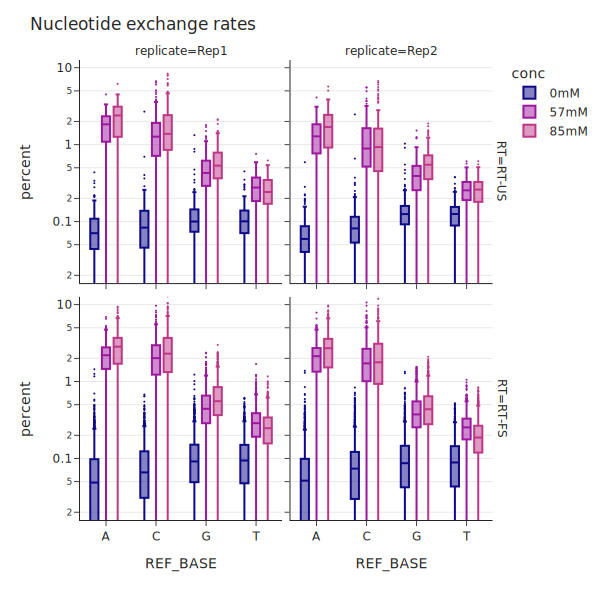

In [241]:
fig = px.box(snm_df[snm_df["DEPTH"]>1000], log_y=True, color="conc",facet_col="replicate", facet_row="RT",x="REF_BASE",  y="percent", category_orders = order_dict, color_discrete_sequence =colorscale)
fig.update_yaxes(range=[-1.8,1.1])
fig.update_layout(height=600, width=600)
fig.update_traces(marker_size=2)
fig.update_layout(title="Nucleotide exchange rates")
fig.write_image(f"{figure_dir}/nanopore_log_snm_rate_per_nt_box.svg")
fig.show(renderer="png")

## Plot mutation patterns

In [218]:
# Calculate mean mismatches per sample and ref base

mean_df = pivot_df.groupby(["sample", "conc", "REF_BASE", "variable"]).agg({"percent" : ["mean"]}).reset_index()
mean_df.columns = ["sample","conc", "REF_BASE", "variable", "percent"]

mean_df["conc"] = pd.Categorical(mean_df["conc"], categories = order_dict["conc"], ordered=True)
mean_df.sort_values(by="conc", inplace=True)

mean_df["conc"] = mean_df["conc"].apply(lambda x: int(x.split("mM")[0]))
mean_df["match"] = mean_df["REF_BASE"] == mean_df["variable"]
mean_df["RT"] = mean_df["sample"].apply(lambda x: x.split("_")[3])
mean_df["replicate"] = mean_df["sample"].apply(lambda x: x.split("_")[2])

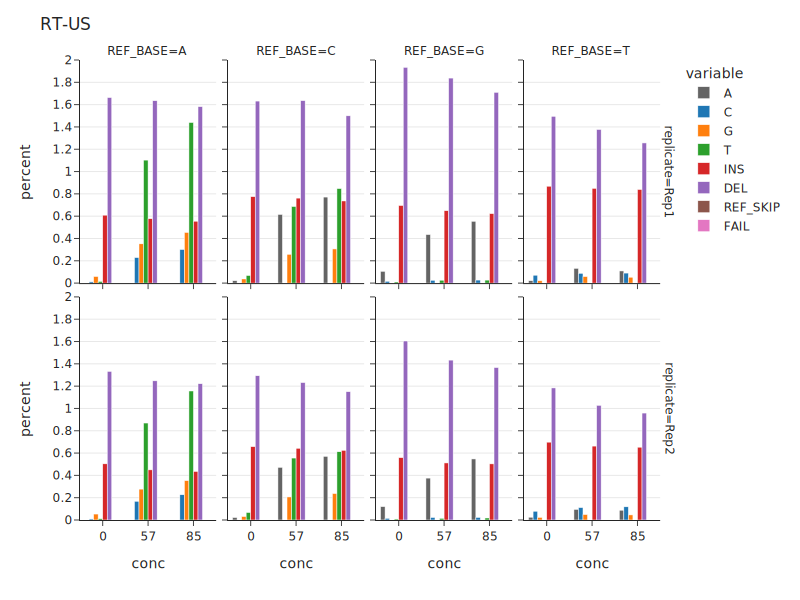

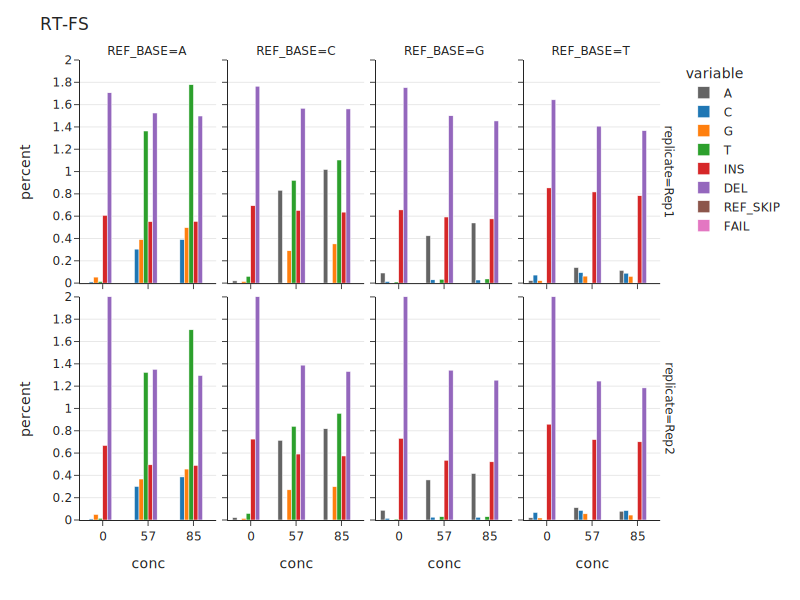

In [219]:
for RT in ["RT-US", "RT-FS"]:
    
    fig = px.bar(mean_df[(~mean_df["match"]) & (mean_df["RT"] == RT)], barmode="group", x="conc", y="percent", facet_row="replicate",color="variable", facet_col="REF_BASE", category_orders = order_dict)
    fig.update_yaxes(range=[0,2], dtick=0.2)
    fig.update_xaxes(type="category")
    fig.update_layout(height=600, width=800, title=RT)
    fig.write_image(f"{figure_dir}/{RT}_mut_type_per_nt_bar.svg")
    fig.show(renderer='png')

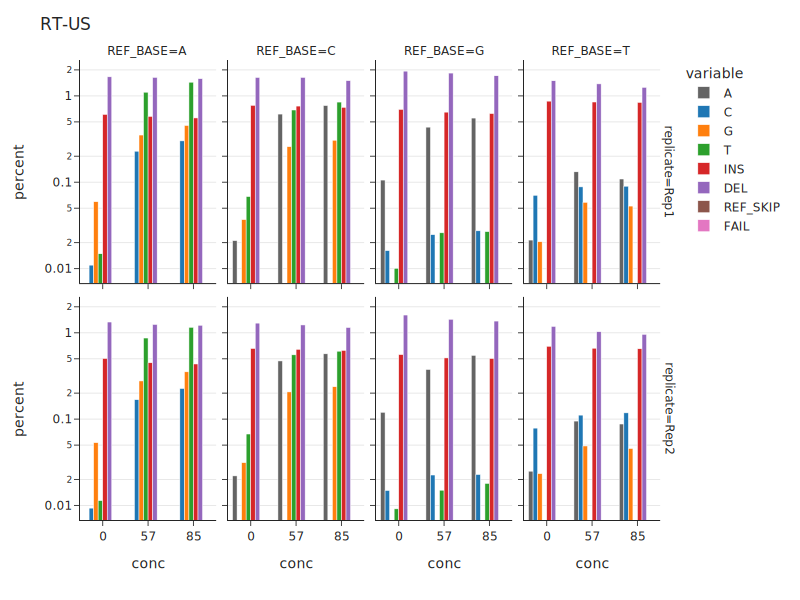

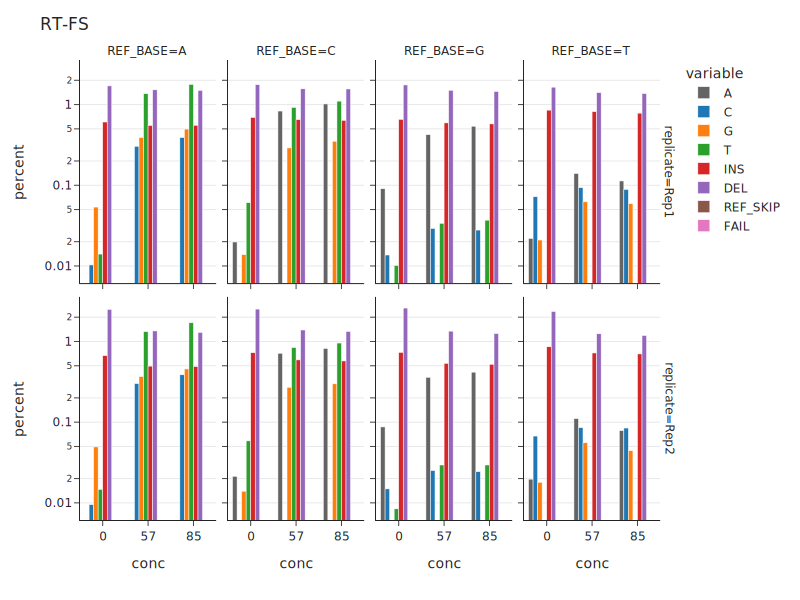

In [161]:
for RT in ["RT-US", "RT-FS"]:
    
    fig = px.bar(mean_df[(~mean_df["match"]) & (mean_df["RT"] == RT)], barmode="group", x="conc", y="percent", facet_row="replicate",color="variable", facet_col="REF_BASE", category_orders = order_dict)
    fig.update_yaxes(type="log")
    fig.update_xaxes(type="category")
    fig.update_layout(height=600, width=800, title=RT)
    fig.write_image(f"{figure_dir}/{RT}_log_mut_type_per_nt_bar.svg")
    fig.show(renderer='png')

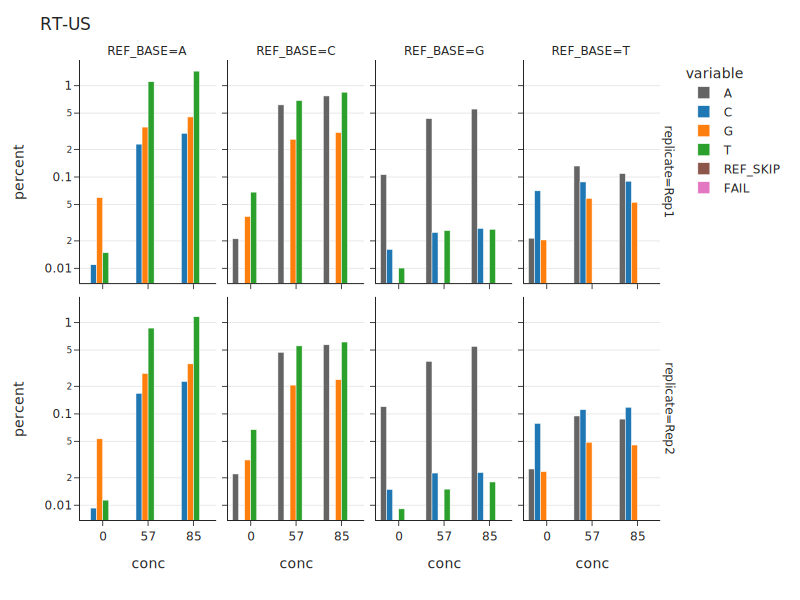

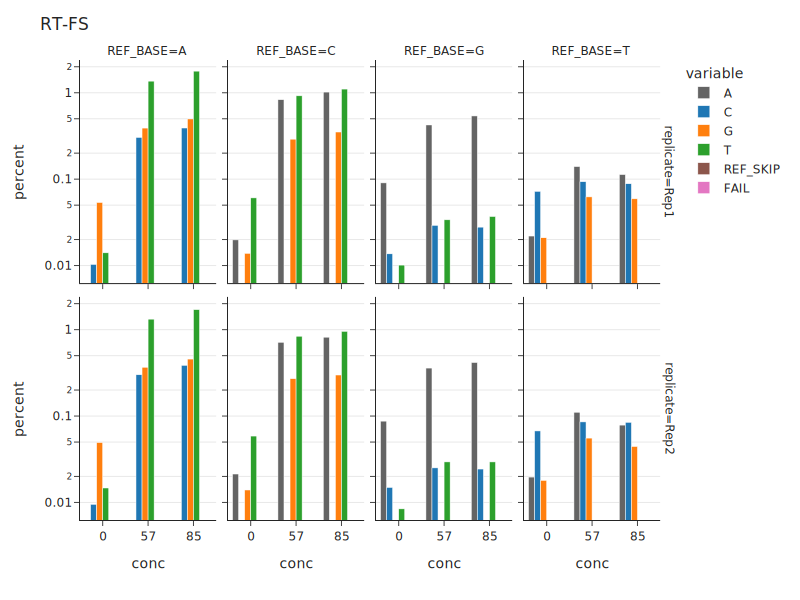

In [162]:
for RT in ["RT-US", "RT-FS"]:
    
    fig = px.bar(mean_df[(~mean_df["match"]) & (mean_df["RT"] == RT) & (~mean_df["variable"].isin(["INS", "DEL"]))], barmode="group", x="conc", y="percent", facet_row="replicate",color="variable", facet_col="REF_BASE", category_orders = order_dict)
    fig.update_yaxes(type="log")
    fig.update_xaxes(type="category")
    fig.update_layout(height=600, width=800, title=RT)
    fig.write_image(f"{figure_dir}/{RT}_log_mut_type_wo_indel_per_nt_bar.svg")
    fig.show(renderer='png')

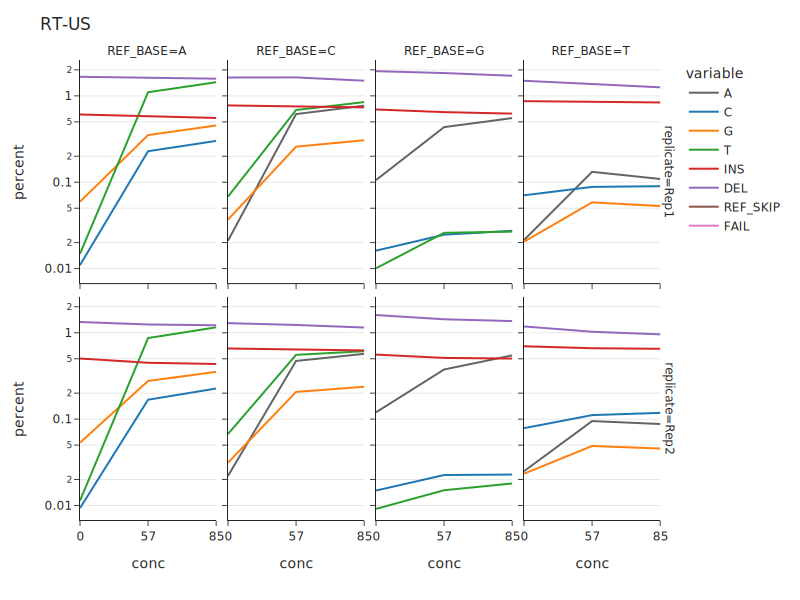

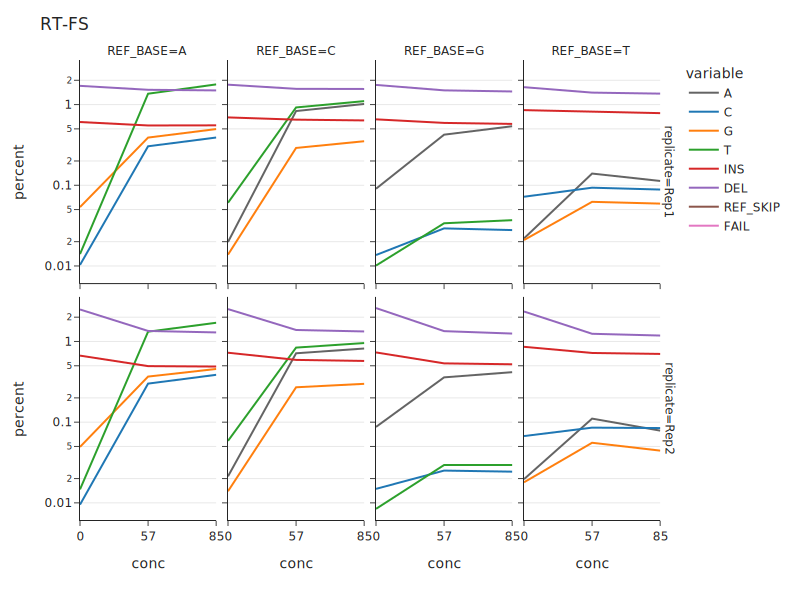

In [163]:
for RT in ["RT-US", "RT-FS"]:
    
    fig = px.line(mean_df[(~mean_df["match"]) & (mean_df["RT"] == RT)], x="conc", y="percent", facet_row="replicate",color="variable", facet_col="REF_BASE", category_orders = order_dict)
    fig.update_yaxes(type="log")
    fig.update_xaxes(type="category")
    fig.update_layout(height=600, width=800, title=RT)
    fig.write_image(f"{figure_dir}/{RT}_log_mut_type_per_nt_line.svg")
    fig.show(renderer='png')

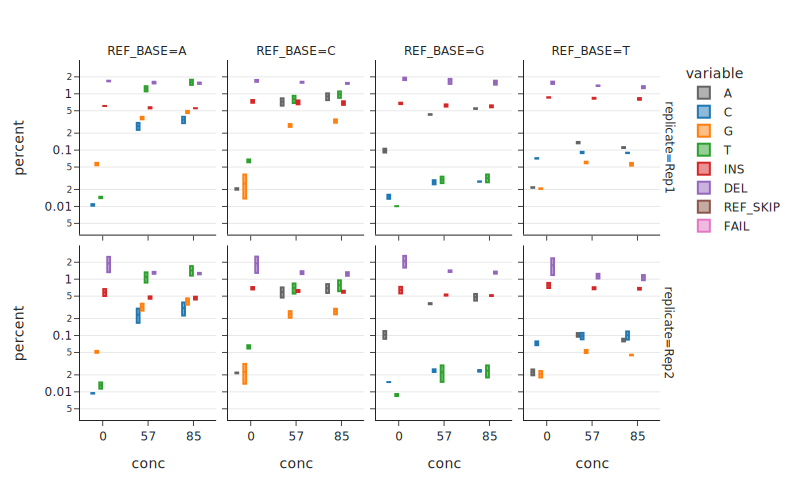

In [220]:
fig = px.box(mean_df, x="conc", y="percent", color="variable", facet_row="replicate", facet_col="REF_BASE", category_orders = order_dict)
fig.update_yaxes(type="log", range=[-2.5,0.6])
fig.update_xaxes(type="category")
fig.update_layout(height=500, width=800)
fig.write_image(f"{figure_dir}/nanopore_mut_type_per_nt_log_line.svg")
fig.show(renderer='png')

## Calculate mean mismatch patterns per isoform to estimate standard deviation

In [295]:
mean_df = pivot_df.groupby(["sample","REF", "conc", "REF_BASE", "variable"]).agg({"percent" : ["mean"]}).reset_index()
mean_df.columns = ["sample","isoform", "conc", "REF_BASE", "variable", "percent"]

mean_df["conc"] = pd.Categorical(mean_df["conc"], categories = order_dict["conc"], ordered=True)
mean_df.sort_values(by="conc", inplace=True)

mean_df["conc"] = mean_df["conc"].apply(lambda x: int(x.split("mM")[0]))
mean_df["match"] = mean_df["REF_BASE"] == mean_df["variable"]
mean_df["RT"] = mean_df["sample"].apply(lambda x: x.split("_")[3])
mean_df["replicate"] = mean_df["sample"].apply(lambda x: x.split("_")[2])

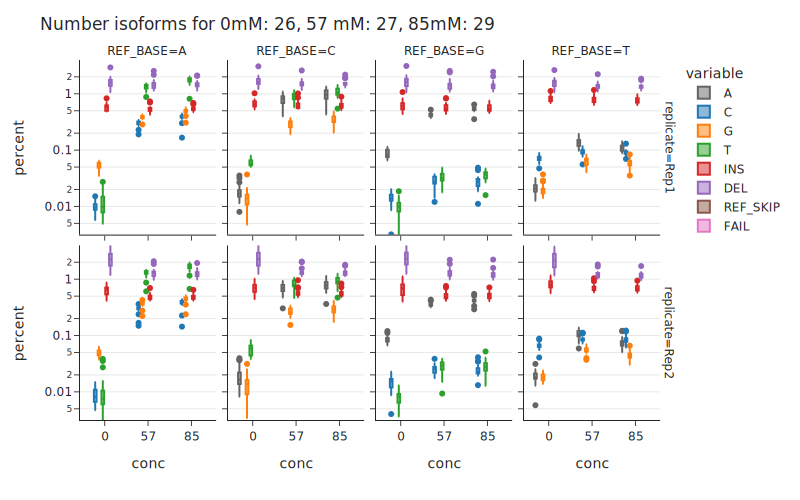

In [276]:
fig = px.box(mean_df, x="conc", y="percent", color="variable", facet_row="replicate", facet_col="REF_BASE", category_orders = order_dict)
fig.update_yaxes(type="log", range=[-2.5,0.6])
fig.update_xaxes(type="category")
fig.update_layout(height=500, width=800, title="Number isoforms for 0mM: 26, 57 mM: 27, 85mM: 29")
fig.write_image(f"{figure_dir}/nanopore_mut_type_per_nt_log_box.svg")
fig.show(renderer='png')

In [297]:
per_isoform_and_RT_df = mean_df.groupby(["replicate","RT", "conc", "REF_BASE", "variable"]).agg({"percent" : ["mean", "std", "count"]}).reset_index()
per_isoform_and_RT_df.columns = ["replicate", "RT", "conc", "REF_BASE", "variable", "mean", "std", "n"]

In [300]:
per_isoform_and_RT_df.groupby(["replicate", "conc"])["n"].value_counts()

replicate  conc  n 
Rep1       0     1     32
                 25    32
           57    1     32
                 26    32
           85    1     32
                 28    32
Rep2       0     1     32
                 25    32
           57    1     32
                 26    32
           85    1     32
                 28    32
Name: n, dtype: int64

In [306]:
per_isoform_df = mean_df.groupby(["replicate", "conc", "REF_BASE", "variable"]).agg({"percent" : ["mean", "std", "count"]}).reset_index()
per_isoform_df.columns = ["replicate", "conc", "REF_BASE", "variable", "mean", "std", "n"]

In [357]:
color_dict = {
    "A" : "rgba(69, 150,6",
    "C" : "rgba(0, 88,155",
    "G" : "rgba(225, 150,68",
    "T" : "rgba(200, 37,60",
    "INS" : "rgba(100,100,100",
    "DEL" : "rgba(110, 30,80",
    "REF_SKIP" : "rgba(88, 88,88",
    "FAIL" : "rgba(150, 150,150",
}

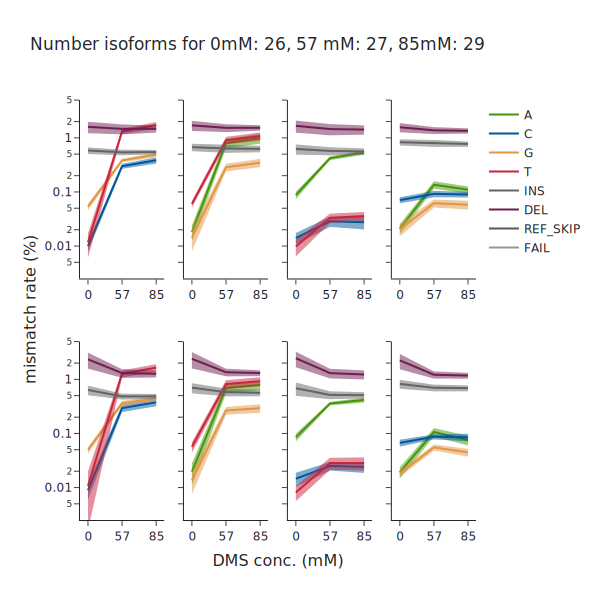

In [365]:
from plotly.subplots import make_subplots

replicates = ["Rep1", "Rep2"]
nts = ["A", "C", "G", "T"]
variables = ["A", "C", "G", "T", "INS", "DEL", "REF_SKIP", "FAIL"]
RTs = ["RT-US", "RT-FS"]

fig = make_subplots(rows=len(replicates), cols = len(nts), shared_yaxes=True, x_title="DMS conc. (mM)", y_title = "mismatch rate (%)")

showlegend=True
for row, rep in enumerate(replicates):
    for col, nt in enumerate(nts):
        sub_df = per_isoform_df[(per_isoform_df["replicate"] == rep) & (per_isoform_df["REF_BASE"] == nt)].dropna()
        for variable in variables:
            sub_sub_df = sub_df[sub_df["variable"] == variable].sort_values("conc")
            if len(sub_sub_df) > 0:
                #print(sub_sub_df)
                this_DMS_conc = sub_sub_df["conc"].values
                mean = sub_sub_df["mean"].values
                std = sub_sub_df["std"].values

                fig.add_trace(go.Scatter(x=this_DMS_conc, y=mean, name=variable, showlegend=showlegend, mode="lines", line=dict(color = color_dict[variable] + ",1)")), row=row+1, col=col+1)

                fig.add_trace(go.Scatter(x=list(this_DMS_conc) + list(this_DMS_conc[::-1]), y=list(mean+std) + list(mean-std)[::-1], showlegend=False, fill="toself", fillcolor=color_dict[variable] + ",.5)", line=dict(color = "rgba(0,100,80, 0)")), row=row+1, col=col+1)
        showlegend=False
fig.update_yaxes(type="log", range=[-2.6,0.7], showgrid=False)
fig.update_layout(height=600, width=600, title="Number isoforms for 0mM: 26, 57 mM: 27, 85mM: 29")
fig.update_xaxes(type="category")
fig.write_image(f"{figure_dir}/log_line_error_w_per_isoform_error_bands_stdev.svg")
fig.show(renderer='png')

# Plot coverage per position per isoform (samtools depth output)

In [183]:
bamstats_folder = f"{data_folder}/bam_stats"
os.makedirs(bamstats_folder, exist_ok=True)

tmp_data = []
for sample in samples:
    
    combined_sample = "_".join(sample.split("_")[3:5]) # adjust to naming scheme
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    sample_outfolder = f"{bamstats_folder}/{sample}/"
    os.makedirs(sample_outfolder, exist_ok=True)
    
    commands = []
    for isoform in sample_isoforms:
        
        coverage_file = f"{sample_outfolder}/coverage_{sample}_{isoform}.csv"
        tmp_df = pd.read_csv(coverage_file, sep="\t", names = ["isoform", "position", "coverage"])
        tmp_df["sample"] = sample
        tmp_data.append(tmp_df)
coverage_df = pd.concat(tmp_data)

In [197]:
coverage_df["replicate"] = coverage_df["sample"].apply(lambda x: x.split("_")[2])
coverage_df["RT"] = coverage_df["sample"].apply(lambda x: x.split("_")[3])
coverage_df["DMS_conc"] = coverage_df["sample"].apply(lambda x: x.split("_")[4])

In [231]:
figure_dir = f"{os.getcwd()}/figures/coverage_plots"
os.makedirs("figures/coverage_plots", exist_ok=True)

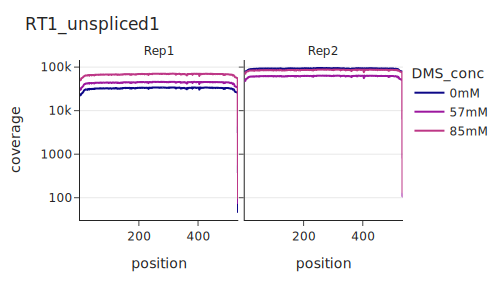

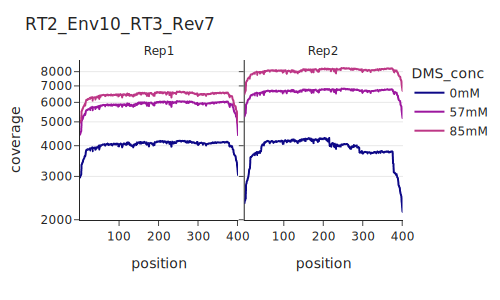

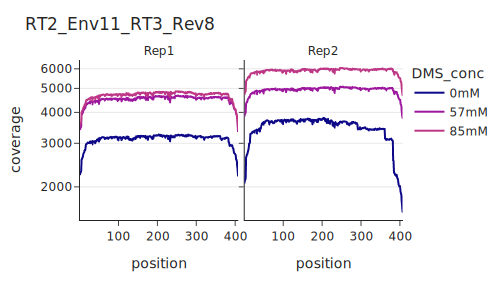

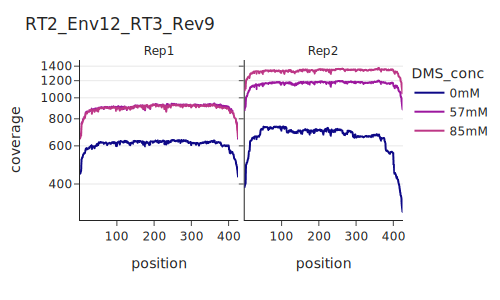

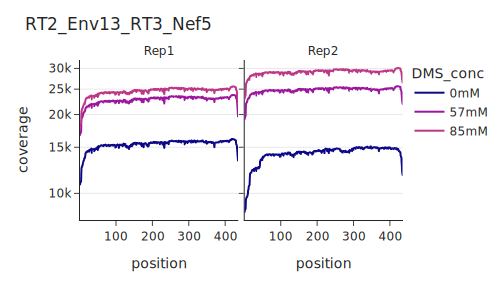

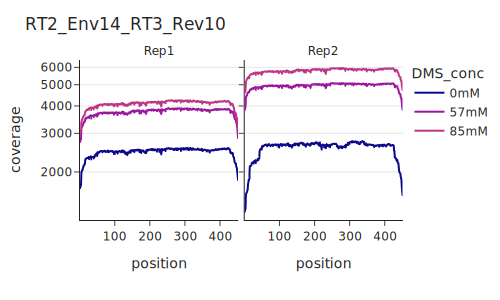

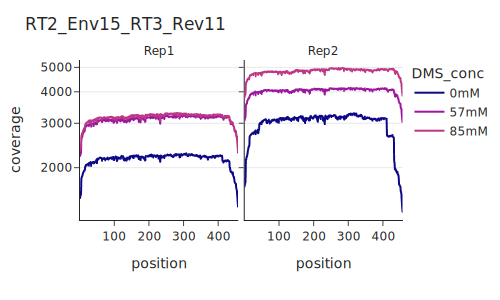

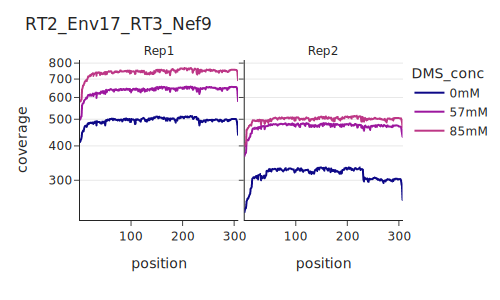

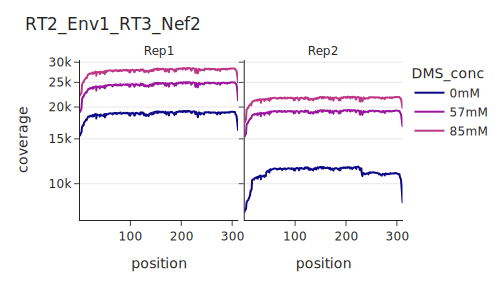

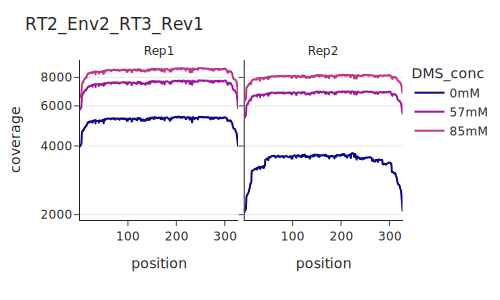

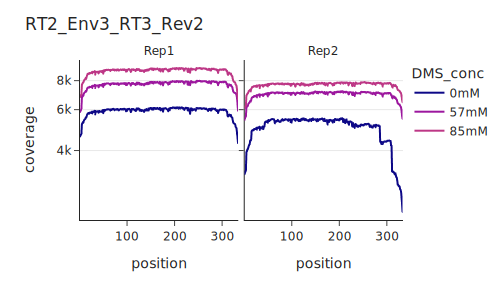

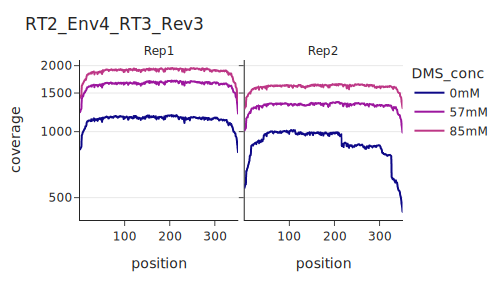

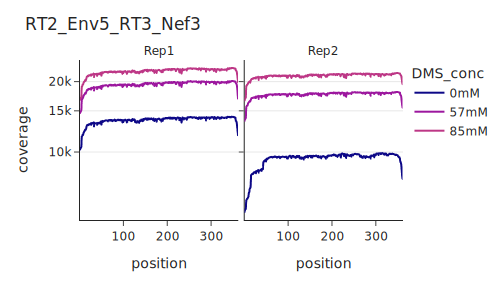

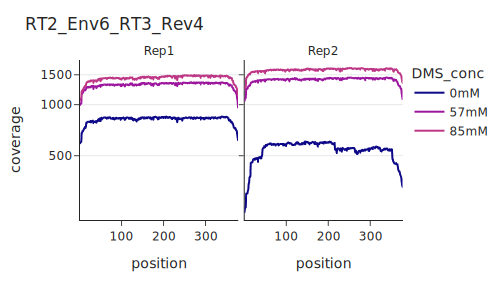

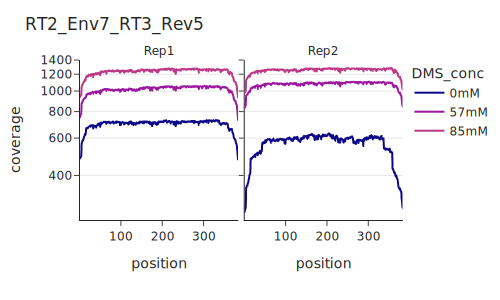

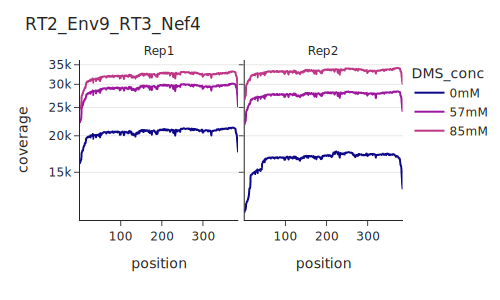

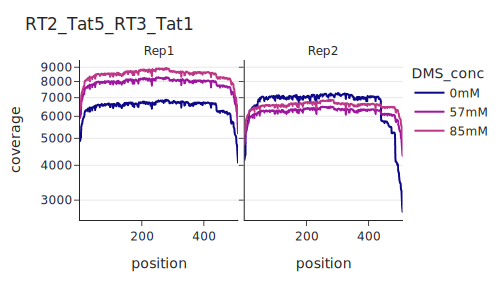

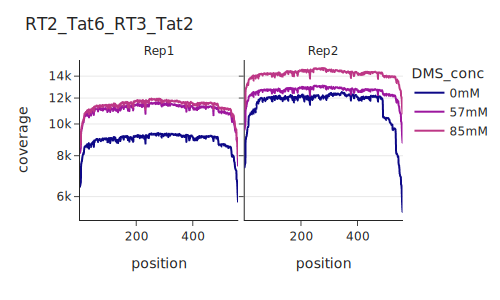

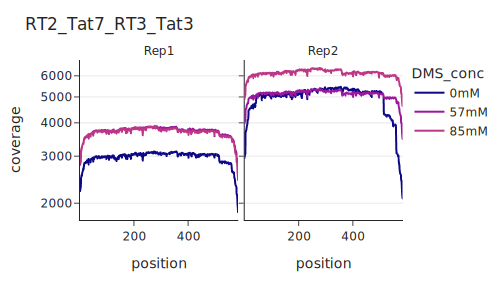

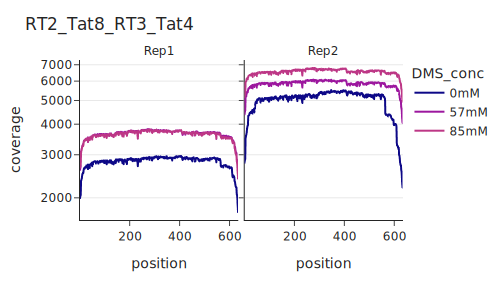

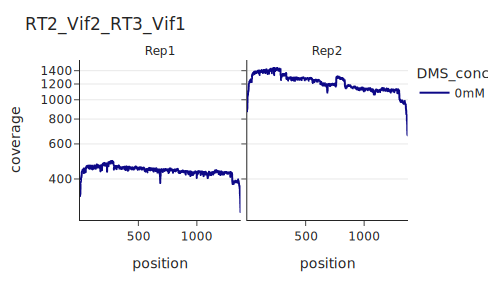

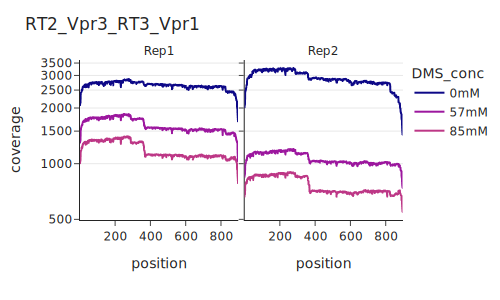

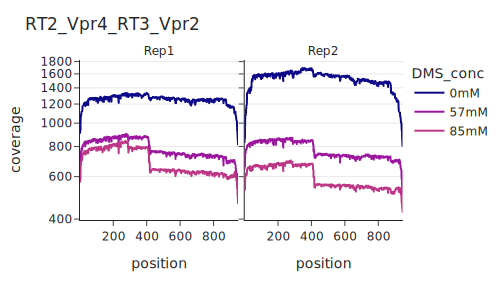

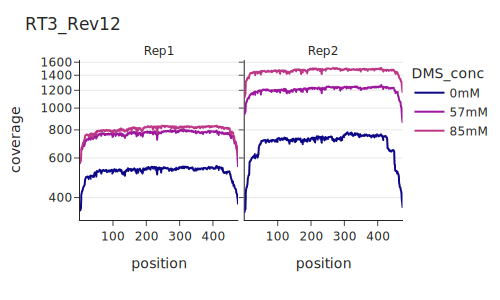

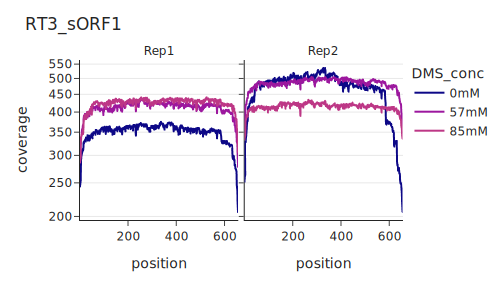

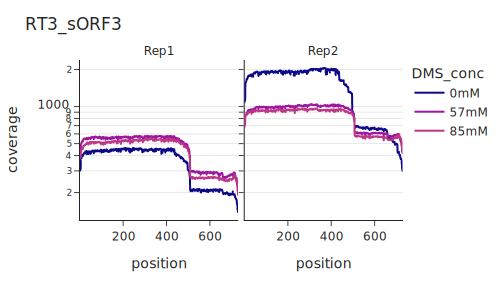

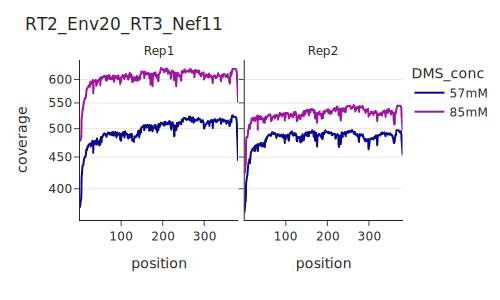

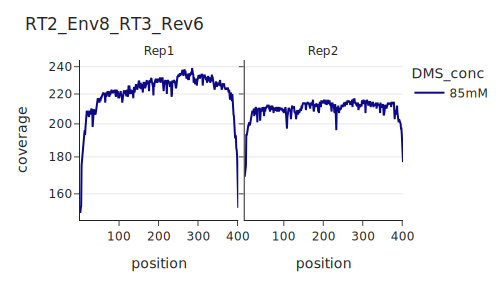

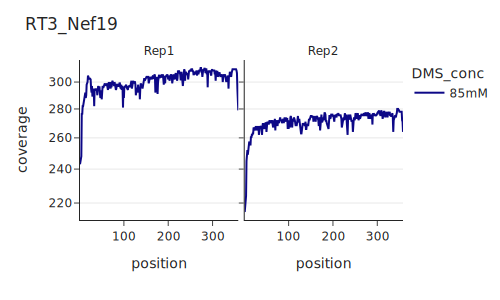

In [200]:
isoforms = coverage_df["isoform"].unique()
for isoform in isoforms:
    
    if isoform == "RT1_unspliced1":
        sub_df = coverage_df[(coverage_df["isoform"] == isoform) & (coverage_df["RT"] == "RT-US")]
        
    else:
        sub_df = coverage_df[(coverage_df["isoform"] == isoform)]
    fig = px.line(sub_df, x="position", facet_col = "replicate", y="coverage", color="DMS_conc", color_discrete_sequence = colorscale)
    fig.update_xaxes(matches=None)
    #fig.update_yaxes(type="log")
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    fig.update_layout(width=500, height=300, title=isoform)
    fig.write_image(f"figures/coverage_plots/{isoform}.svg")
    fig.update_yaxes(type="log")
    fig.write_image(f"{figure_dir}/log_{isoform}.svg")
    fig.show(renderer='png')